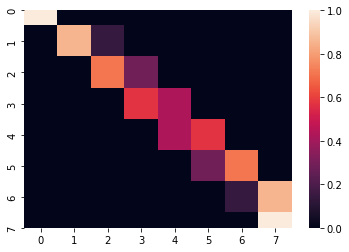

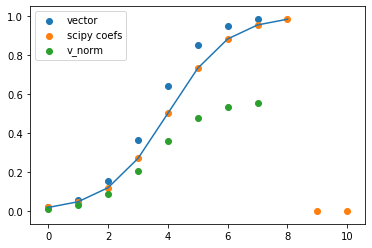

Condition number
 62.475138845718426
norm(yk) 1.7725695980871499


In [1]:
from vqls import *
from utils import *
lower = 0.
upper = 1. 
n_step = 8
f_i = 0.0  
MAX_ITER = 15

nq=3
# K = 2^n = dim(T)-2
# with dim(S) = KxK
# n = num qubits
# T = set of knots

scaled=False

label = 'sigmoid'
func = sigmoid_t


x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
  norm = np.linalg.norm(y)
  y = y / norm
tck=splrep(x,y,k=1) #coeffs
#plt.scatter(range(len(tck[1])),tck[0], label = "scipy knots")


#############################################################################################
###################################### System Preparation ###################################
#############################################################################################

matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled);

import seaborn as sns

sns.heatmap(matrix)
plt.show()
plt.plot(y)

plt.scatter(range(len(vector)), vector, label="vector")
plt.scatter(range(len(tck[1])),tck[1], label="scipy coefs")
plt.scatter(range(len(v_norm)), v_norm, label="v_norm")
plt.legend()
plt.show()
#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################

k_numb=np.linalg.cond(np.array(matrix))
print('Condition number\n',k_numb)
print('norm(yk)',np.linalg.norm(vector))




In [2]:
df = pd.read_json("results.json")
df

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,62.475139,1.77257,[0.25583961250000004],110.668217,"[[1.1766524858, 2.9867570807, 2.2996267901, 1....",3.332392,3.145764,42


## asbgn


In [2]:
import time
#weights = np.load("weights_8.npy")

26
Optimizing variational params..
Starting parameters = [1.47349139 3.07472138 1.53049065 2.52015014 1.0908926  1.04930813
 2.71337433 2.26779033 1.94783549]
Cost at Step 0: 0.4918703
Cost at Step 1: 0.3092266
Cost at Step 2: 0.4067322
Cost at Step 3: 0.4835778
Cost at Step 4: 0.2477819
Cost at Step 5: 0.0987249
Cost at Step 6: 0.1186288
Cost at Step 7: 0.2905843
Cost at Step 8: 0.1084887
Cost at Step 9: 0.1273617
Cost at Step 10: 0.0056916
Cost at Step 11: 0.0756313
Cost at Step 12: 0.0314933
Cost at Step 13: 0.1202015
Cost at Step 14: 0.0367755
Cost at Step 15: 0.0056916
Final cost function 0.005691646254263993
Number of steps 16
The time of execution of above program is : 3660.784609079361
(<Figure size 720x288 with 1 Axes>, <Axes:>)
Quantum coefficients         : [-0.0529764 +0.j -0.05767231+0.j -0.05358677+0.j -0.13026156+0.j
 -0.339635  +0.j -0.45242049+0.j -0.53712319+0.j -0.60455788+0.j]
Variational Circuit's weights: [2.96626092 2.81165309 1.06009414 3.68592692 2.49304582 0.9

d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


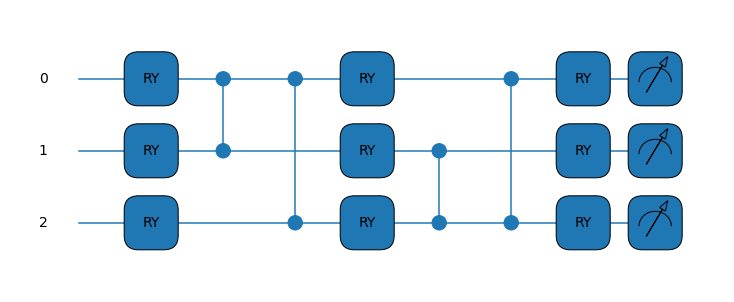

In [3]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

print('Optimizing variational params..')
start = time.time()
weights = vqls_circuit.train(max_iter=MAX_ITER)  
end = time.time()
print("The time of execution of above program is :", end-start)
q = vqls_circuit.solution(weights, True)
print('Quantum coefficients         :',q)
print("Variational Circuit's weights:",weights)


In [4]:
np.save(f"weights_{n_step}_{MAX_ITER}", weights)

(<Figure size 720x288 with 1 Axes>, <Axes:>)


tensor([-0.0529764 +0.j, -0.05767231+0.j, -0.05358677+0.j,
        -0.13026156+0.j, -0.339635  +0.j, -0.45242049+0.j,
        -0.53712319+0.j, -0.60455788+0.j], requires_grad=True)

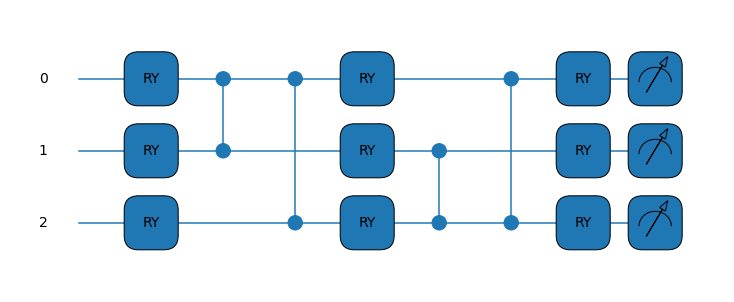

In [5]:
q = vqls_circuit.solution(weights, True)
q

## aosiegn


In [10]:
#Classic beta coefficients
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
print('beta  qunatum')
y_c=np.dot(matrix,c) #classic


y_q=np.dot(matrix,q) #hybrid
                     #Quantum
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))
rss_full = np.sum(np.square(np.array(y_c) - np.array(y_fq)))
rss_hybr = np.sum(np.square(np.array(y_c) - np.array(y_q)))

print('RSS_q:',rss_full)
print('RSS_h:',rss_hybr)



beta_classic                 : [ 0.01798621  0.07173906 -0.0502415   0.65973407 -0.0375285   1.14655868
  0.7277244   0.98201379]
beta  qunatum
RSS_q: 9.449024970612228
RSS_h: (8.23628511027482+0j)


d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


In [17]:
np.save(f"in_training_weight_{n_step}_{MAX_ITER}", vqls_circuit.testing_product)

In [30]:
y_train_fq = []
for i in range(len(vqls_circuit.testing_product)):
      y_fq = []
      for el in matrix:
            y_fq.append(vqls_circuit.direct_prod2(vqls_circuit.testing_product[i],el))
      y_train_fq.append(y_fq)

d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,
d:\conda\envs\res\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


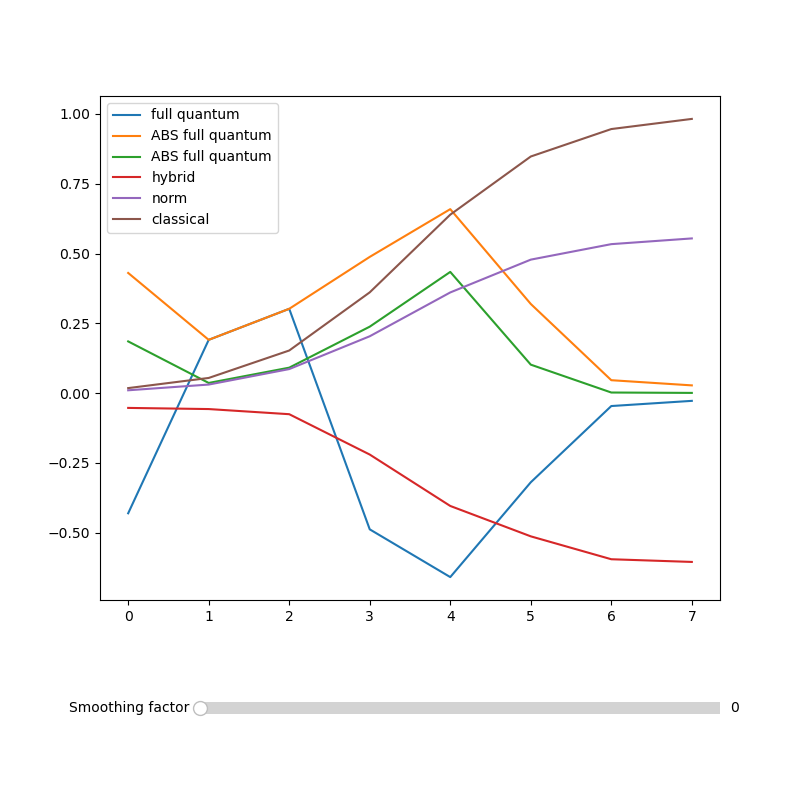

In [51]:
%matplotlib widget 
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
# Initial x and y arrays
# Spline interpolation
# Plotting
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(vqls_circuit.testing_product[0],el))

fig = plt.figure(figsize=[8,8])

plt.subplots_adjust(bottom=0.25)
ax = fig.subplots()
plt.legend()

p = ax.plot(range(len(y_fq)),y_fq, label= "full quantum")
h = ax.plot(range(len(y_fq)),np.abs(y_fq), label= "ABS full quantum")
b = ax.plot(range(len(y_fq)),np.power(y_fq,2), label= "ABS full quantum")

plt.plot(range(len(y_fq)),y_q,label= "hybrid")
plt.plot(range(len(y_fq)),v_norm,label= "norm")
plt.plot(range(len(y_fq)),y_c,label="classical")
plt.legend()

# Defining the Slider button
# xposition, yposition, width and height
ax_slide = plt.axes([0.25, 0.1, 0.65, 0.03])


# Properties of the slider
s_factor = Slider(ax_slide, 'Smoothing factor',
                0, len(vqls_circuit.testing_product)-1, valinit=0, valstep=1)

# Updating the plot
def update(val):
    current_v = s_factor.val
    p[0].set_ydata(y_train_fq[current_v])
    h[0].set_ydata(np.abs(y_train_fq[current_v]))
    b[0].set_ydata(np.power(y_train_fq[current_v],2))
    #redrawing the figure
    fig.canvas.draw()
    
# Calling the function "update" when the value of the slider is changed
s_factor.on_changed(update)
plt.show()

d:\conda\envs\res\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


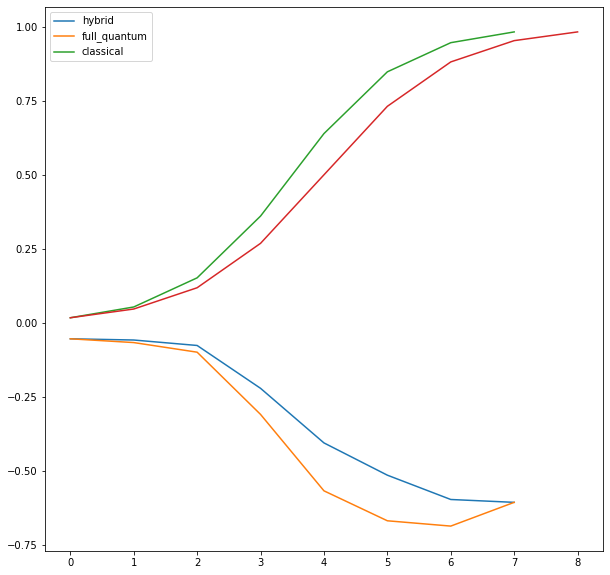

In [12]:
plt.figure(figsize=(10,10))
plt.plot(range(len(y_fq)),y_q,label= "hybrid")
plt.plot(range(len(y_fq)),y_fq, label="full_quantum")
plt.plot(range(len(y_fq)),y_c, label="classical")
plt.plot(y)
plt.legend()

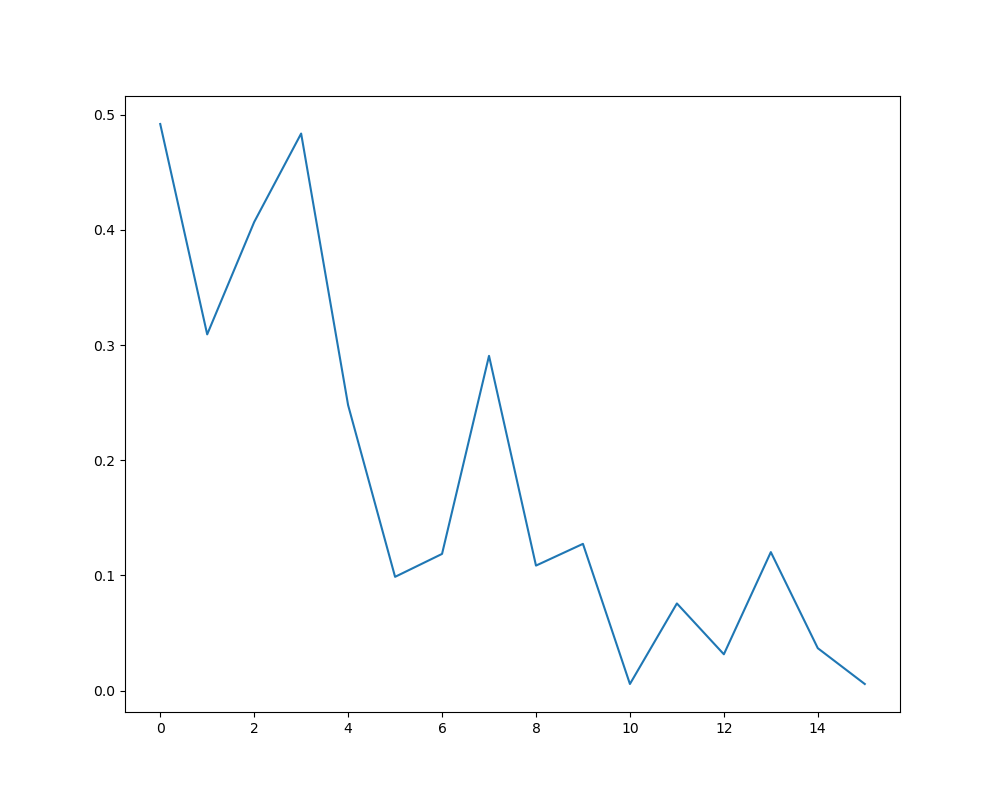

In [53]:
plt.figure(figsize=(10,8))
plt.plot(vqls_circuit.cost_vals);